# Descripción del problema

El análisis de redes sociales está sin lugar a dudas convirtiendose cada vez más en foco de atención. Uno de los aspectos más relevantes es el procesamiento computacional de los contenidos vertidos en ellas.

Más aún: En el contexto actual de medios de difusión masivos de Argentina, es importante destacar la importancia de la circulación de información de medios alternativos que no sean los hegemónicos. En este sentido, el compartir datos en redes sociales, con la posibilidad siempre abierta de convertirse en tendencias (a escalas nacionales, regionales o mundiales) y tener un gran impacto en el escenario discursivo, hace de las redes sociales una herramienta de poder no menor.

Este trabajo pretende hacer un análisis exploratorio de un conjunto de datos extraidos de la red social Twitter. En este primer acercamiento se cuenta con un conjunto pequeño de tweets publicados antes del debate del proyecto de aborto en el senado de la nación Argentina.

El análisis exploratorio tiene como objectivo agrupar conjuntos de tweets en común en clústers, y, para dar una idea de la población general, se elegirán los tweets representativos de dichos clústers.

Para caracterizar los tweets y abstraerlos para su agrupamiento se usaron _embeddings neuronales_ de la libreria [FastText](https://fasttext.cc/).


Este trabajo tiene como inspiración (y estabasado en) el análisis disponible [aquí](https://github.com/pablocelayes/twitter-aborto).

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
# %load_ext memory_profiler  # pip install memory_profiler

In [3]:
# read tweets for
tweets_data_path_si = '../data/tweets_si.json'

tweets_file_si = open(tweets_data_path_si, "r")
tweets_data_si = json.load(tweets_file_si)

# read tweets against
tweets_data_path_no = '../data/tweets_no.json'

tweets_file_no = open(tweets_data_path_no, "r")
tweets_data_no = json.load(tweets_file_no)

# add tagging for postitioning on topic
[x.update({'position': 'no'}) for x in tweets_data_no]
[x.update({'position': 'si'}) for x in tweets_data_si]

# merge
tweets_data_all = tweets_data_no + tweets_data_si

In [4]:
print('Cantidad a favor: {}\t\tCantidad en contra: {}'.format(len(tweets_data_no), len(tweets_data_si)))

Cantidad a favor: 1847		Cantidad en contra: 2462


In [5]:
# Raw print of one example
tweets_data_all[5]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Apr 17 11:02:42 +0000 2018',
 'entities': {'hashtags': [],
  'symbols': [],
  'urls': [{'display_url': 'twitter.com/i/web/status/9…',
    'expanded_url': 'https://twitter.com/i/web/status/986198259982110722',
    'indices': [116, 139],
    'url': 'https://t.co/oSTwbQUCoH'}],
  'user_mentions': [{'id': 182923335,
    'id_str': '182923335',
    'indices': [0, 11],
    'name': 'Radio Mitre',
    'screen_name': 'radiomitre'}]},
 'favorite_count': 0,
 'favorited': False,
 'geo': None,
 'id': 986198259982110722,
 'id_str': '986198259982110722',
 'in_reply_to_screen_name': 'radiomitre',
 'in_reply_to_status_id': 986190097933635584,
 'in_reply_to_status_id_str': '986190097933635584',
 'in_reply_to_user_id': 182923335,
 'in_reply_to_user_id_str': '182923335',
 'is_quote_status': False,
 'lang': 'es',
 'metadata': {'iso_language_code': 'es', 'result_type': 'recent'},
 'place': None,
 'position': 'no',
 'retweet_count': 0,
 'retweet

In [6]:
# Cut some of the tweets data
def recortar_tweet(t):
    COLUMNAS = ['created_at', 'favorite_count', 'retweet_count', 'text', 'position']
    tweet_recortado = {columna: t[columna] for columna in COLUMNAS}
    tweet_recortado['user_name'] = t['user']['name']
    return tweet_recortado

In [7]:
recortar_tweet(tweets_data_all[0])

{'created_at': 'Tue Apr 17 11:40:55 +0000 2018',
 'favorite_count': 0,
 'position': 'no',
 'retweet_count': 12,
 'text': 'RT @LAM_Oficial: ¡Si a la Vida!¡No al aborto! #NoAlAborto',
 'user_name': 'john giraldo'}

In [8]:
# Dataframe from cutted tweets
recortados = [recortar_tweet(t) for t in tweets_data_all]
tweets = pd.DataFrame(recortados)

In [9]:
tweets.text[0]

'RT @LAM_Oficial: ¡Si a la Vida!¡No al aborto! #NoAlAborto'

In [10]:
# pandas default datatype given
tweets.dtypes

created_at        object
favorite_count     int64
position          object
retweet_count      int64
text              object
user_name         object
dtype: object

In [11]:
# Convert datatype of created_at column for better manipulation
tweets['created_at'] = pd.to_datetime(tweets['created_at'])
tweets.dtypes

created_at        datetime64[ns]
favorite_count             int64
position                  object
retweet_count              int64
text                      object
user_name                 object
dtype: object

In [12]:
tweets.head()

,created_at,favorite_count,position,retweet_count,text,user_name
0,2018-04-17 11:40:55,0,no,12,RT @LAM_Oficial: ¡Si a la Vida!¡No al aborto! ...,john giraldo
1,2018-04-17 11:38:08,0,no,24,RT @PattRam74: Ahora a la izquierda le dió con...,Mario Astorga
2,2018-04-17 11:15:34,0,no,37,RT @BalleriniVIDA: Las mujeres pobres aman a s...,jorge antunez
3,2018-04-17 11:12:13,0,no,0,"@clarincom ""La preocupación por la vida no ata...",Veronica Vocos 🇦🇷
4,2018-04-17 11:05:41,0,no,9,RT @VotoCatolicoES: #NoAlAborto \nEL DÍA EN QU...,Janet Cienfuegos


## Linea de tiempo de tuiteo

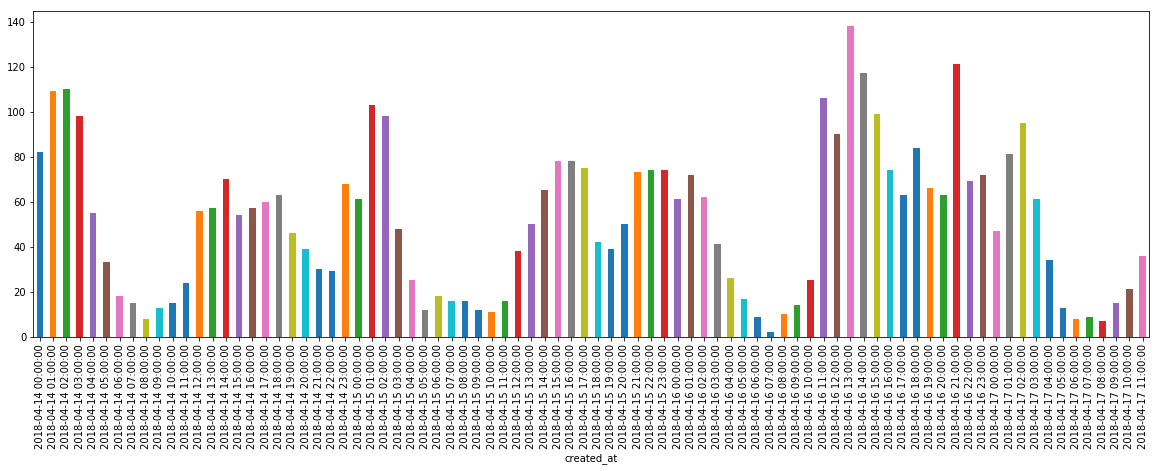

In [13]:
for_plt = tweets.set_index('created_at', drop=False, inplace=False)
for_plt.created_at.groupby(pd.Grouper(freq='H')).count().plot(kind='bar', figsize=(20, 6))
# TODO: plot discriminating over position taken

# Trabajo solo con texto


## Normalización


In [14]:
txt_tweets = tweets['text']

In [15]:
# remove retweets (highly probable repetition on dataset)
txt_tweets = txt_tweets[~txt_tweets.str.startswith('RT')]
txt_tweets_position = tweets[~tweets['text'].str.startswith('RT')]['position']
# TODO: remove really short tweets!!
txt_tweets_position.value_counts()

no    502
si    479
Name: position, dtype: int64

In [16]:
import re
import unicodedata

# for solutions without embedding?
# from stop_words import get_stop_words

# STOPWORDS = get_stop_words('en')
# STOPWORDS.extend(get_stop_words('es'))


def preprocess(doc):
    pre_doc = doc
        
    # remove URLs
    pre_doc = re.sub(
        r"https?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
        " ", pre_doc)
        
    # find and split hashtags
    pre_doc = re.sub(r"(?:^|\s)[＃#]{1}(\w+)", 
            lambda s: re.sub(r"([A-Z])", r" \1", s.group(0)) if len(s.group(0)) > 5 else s.group(0), 
            pre_doc)
    pre_doc = re.sub(r"＃|#", " ", pre_doc)
    
    # lowercase everything
    pre_doc = pre_doc.lower()
        
    # remove rare chars
    pre_doc = re.sub(r"\@|\'|\"|\\|…|\/|\-|\||\(|\)|\.|\,|\!|\?|\:|\;|“|”|’|—", " ", pre_doc)
    
    # normalize whitespaces
    pre_doc = re.sub(r"\s+", " ", pre_doc)
    pre_doc = re.sub(r"(^\s)|(\s$)", "", pre_doc)
    
    # TODO: remove emojis!
    # TODO: lemmatize?
    
    # remove accents? it also turns ñ to n..
    pre_doc = ''.join(c for c in unicodedata.normalize('NFD', pre_doc) if unicodedata.category(c) != 'Mn')
    
    return pre_doc

In [17]:
txt_tweets = txt_tweets.apply(preprocess)

# Embeddig con FastText

In [18]:
%%time
# copy tweets text to temporary file
text_tw = txt_tweets
with open('tweets.txt', 'w+') as f:
    for t in text_tw:
        f.write(t + '\n')

CPU times: user 2.07 ms, sys: 195 µs, total: 2.27 ms
Wall time: 1.68 ms


In [19]:
%%time
%%memit # not detecting os execution?
import os
# get vectors with pre-trained model in spanish. Very memory consuming!
# fastext_bin_dir = "/home/emanuel/fastText/fastText"
# model_path = "/home/emanuel/fastText/models/wiki.es.bin"
# input_file_path = "tweets.txt"
# output_file_path = "tweets.ftvec"
# cmd = "{}/fasttext print-sentence-vectors {} < {} > {}".format(fastext_bin_dir,
#                                                               model_path,
#                                                               input_file_path,
#                                                               output_file_path)
# print("executing: {}".format(cmd))
# os.system(cmd)

ERROR:root:Cell magic `%%memit` not found.


CPU times: user 3.19 ms, sys: 0 ns, total: 3.19 ms
Wall time: 2.58 ms


In [20]:
# get embeddings from file
output_file_path = "tweets.ftvec"
with open(output_file_path, "r") as f:
    lines = f.readlines()

# parse line to splitted string
lines = [l.split(" ")[:-1] for l in lines]

In [21]:
import numpy as np
X_feat = np.zeros((len(text_tw), 300))
X_feat[:,:] = lines
X_tweets = text_tw

# Clustering

In [22]:
from sklearn.cluster import KMeans
# test example
kmeans = KMeans(n_clusters=5, random_state=1).fit(X_feat)
X_cluster = kmeans.predict(X_feat)
df_tweets = pd.DataFrame({'text': X_tweets, 'cluster': X_cluster, 'position': txt_tweets_position})
df_tweets.cluster.value_counts(normalize=True)

1    0.483180
3    0.352701
0    0.112130
2    0.040775
4    0.011213
Name: cluster, dtype: float64

In [23]:
# function to get closest tweets to centroid in cluster
def get_closest_tweets(X_trans, clust, max_t=10):
    idx = np.argsort(X_trans[:, clust])[::-1][:50]
    tweets = X_tweets.iloc[idx].drop_duplicates()
    return tweets[:max_t]

Buen comienzo! no hay clases excesivamente mayoritarias 

### Muestra de ejemplo para diferentes K

In [24]:
for nclust in range(2,11, 2):
    print('\n\n\t\t\t\t\tResultados para k-means, K = {}\n'.format(nclust))
    kmeans = KMeans(n_clusters=nclust, random_state=1).fit(X_feat)
    X_cluster = kmeans.predict(X_feat)
    X_transformed = kmeans.transform(X_feat)
    df_tweets = pd.DataFrame({'text': X_tweets, 'cluster': X_cluster, 'position': txt_tweets_position})
    print('\tDistribución de frecuencias por cluster')
    print('clust\tfrequencia')
    print('{}'.format(df_tweets.cluster.value_counts(normalize=True)))
    print('\n\tTweets más cercanos por cluster')
    for c in range(nclust):
        closest_tweets_to_centroid = get_closest_tweets(X_transformed, c, max_t=5)
        print('\tCluster {}, tweets:'.format(c))
        print(closest_tweets_to_centroid)
        print('\n')
    # TODO: get fastext representation of centroid?



					Resultados para k-means, K = 2

	Distribución de frecuencias por cluster
clust	frequencia
0    0.950051
1    0.049949
Name: cluster, dtype: float64

	Tweets más cercanos por cluster
	Cluster 0, tweets:
587                 noalaborto
3489               abortolegal
1436    milifarina2 noalaborto
2790              aborto legal
460       noalaborto sialavida
Name: text, dtype: object


	Cluster 1, tweets:
589                                            noalaborto
2430    el salvador watch the video on these courageou...
3014    probirth politicians propose death penalty wom...
81                                      n oal a b o r t o
2413                   lalugalvanok a b o r t o l e g a l
Name: text, dtype: object




					Resultados para k-means, K = 4

	Distribución de frecuencias por cluster
clust	frequencia
0    0.654434
2    0.169215
1    0.141692
3    0.034659
Name: cluster, dtype: float64

	Tweets más cercanos por cluster
	Cluster 0, tweets:
607                 noalaborto
30

### Métrica Silhouette

Trataremos de encontrar un valor aceptable para K usando la métrica silhouette.

In [25]:
from sklearn.metrics import silhouette_score

for n_clust in range(2,15):
    kmeans = KMeans(n_clusters=n_clust, random_state=1)
    X_cluster = kmeans.fit_predict(X_feat)
    silhouette_avg = silhouette_score(X_feat, X_cluster)
    print('K = {}\tSilhouette average: {}'.format(n_clust, silhouette_avg))

K = 2	Silhouette average: 0.45844720380053683
K = 3	Silhouette average: 0.08803735097701343
K = 4	Silhouette average: 0.13307336084792187
K = 5	Silhouette average: 0.10801017676890826
K = 6	Silhouette average: 0.09508983381804954
K = 7	Silhouette average: 0.09896945278657092
K = 8	Silhouette average: 0.10601023538588579
K = 9	Silhouette average: 0.09360738998387101
K = 10	Silhouette average: 0.09338289382104782
K = 11	Silhouette average: 0.09744946381975789
K = 12	Silhouette average: 0.09586269957808449
K = 13	Silhouette average: 0.0984343388765848
K = 14	Silhouette average: 0.09844685432977207


Luego de variar un poco la semilla de aleatoriedad, los resultados mostrados aquí no cambian mucho. K=2 es mejor opcion por lejos.

### Fijar modelo para posteriores métricas

Primero obtenemos un modelo fijo con algunas métricas y datos.

In [26]:
n_clust = 2
kmeans = KMeans(n_clusters=n_clust, random_state=1).fit(X_feat)
X_cluster = kmeans.predict(X_feat)
X_transformed = kmeans.transform(X_feat)
df_tweets = pd.DataFrame({'text': X_tweets, 'cluster': X_cluster, 'position': txt_tweets_position})
print('\tDistribución de frecuencias por cluster')
print('clust\tfrequencia')
print('{}'.format(df_tweets.cluster.value_counts(normalize=True)))
print('\n\tTweets más cercanos por cluster')
for c in range(n_clust):
    closest_tweets_to_centroid = get_closest_tweets(X_transformed, c, max_t=20)
    print('\tCluster {}, tweets:'.format(c))
    for t in closest_tweets_to_centroid:
        print(t)
    print('\n')

	Distribución de frecuencias por cluster
clust	frequencia
0    0.950051
1    0.049949
Name: cluster, dtype: float64

	Tweets más cercanos por cluster
	Cluster 0, tweets:
noalaborto
abortolegal
milifarina2 noalaborto
aborto legal
noalaborto sialavida
sialavida noalaborto
abortolegal💪 abajolaclandestinidad
lmneuquen noalaborto sialavida
probirth politicians propose death penalty women can simply remove what they want 1000 s of arson bombings shoot
el salvador watch the video on these courageous women who faced pregnancy complications and ended up in prison in
lanus zonasur panuelazo abortolegal
aborto legal aborto legal ya
aborto legal ya aborto legal
n oal aborto
almagro_oea2015 gustavolainette isabelstmalo jorgefaurie cepal_onu aliciabarcena canadaoas gwynethkutz
repost pathyonline get_repost ・・・ sialavida noalaborto
amnesty chief calls latin america s abortion laws violence against women latinoamerica aborto legal
aborto legal eltiempoesahora
mariano_bondar aborto legal
aborto legal y

No se obtuvo la división tajante que se esperaría: el reconocer posiciones a favor y en contra. Esto se puede ver además en la desproporción de los tamaños de los clústers:

In [27]:
df_tweets.position.value_counts(normalize=True)

no    0.511723
si    0.488277
Name: position, dtype: float64

Este comportamiento puede atribuirse a ciertas limitaciones que se encontrarion:
- Los textos de los tweets se encuentran cortados: tweets con más de 140 caracteres se cierran con puntos suspensivos.
- Muchos tweets muy cortos: Existen muchos tweets que cuentan con una pronunciación escueta con respecto al tema, lo cual puede traer ruido a la hora de clasificar con K-Means.

A continuación se presentan algunas métricas para comparar la pertenencia de un tweet a un cluster con la posición a favor o en contra:

Dado que su posisión sea en contra o a favor de la legalización, la pertenencia algún cluster NO presenta una mayoría relevante

In [28]:
df_tweets[df_tweets.position == 'no'].cluster.value_counts()

0    496
1      6
Name: cluster, dtype: int64

In [29]:
df_tweets[df_tweets.position == 'si'].cluster.value_counts()

0    436
1     43
Name: cluster, dtype: int64

Y a la inversa: dado que pertenecen a un clúster, la posisión en contra o a favor de la legalización no destaca.

In [30]:
df_tweets[df_tweets.cluster == 0].position.value_counts()

no    496
si    436
Name: position, dtype: int64

In [31]:
df_tweets[df_tweets.cluster == 1].position.value_counts()

si    43
no     6
Name: position, dtype: int64